In [1]:
import pandas as pd  # For data manipulation
import numpy as np  # For data manipulation
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For data visualization
from sklearn.model_selection import train_test_split  # For splitting the data into train and test
from sklearn.linear_model import LinearRegression  # For training the algorithm
from sklearn.tree import DecisionTreeRegressor  # For training the algorithm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  # For training the algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR  # For training the algorithm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor  # For training the algorithm
from tensorflow import keras  # For training the algorithm
from tensorflow.keras import layers  # For training the algorithm
import tensorflow as tf  # For training the algorithm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lifelines import CoxPHFitter  # For Cox Proportional Hazards Model
from reliability.Fitters import Fit_Weibull_2P, Fit_Weibull_ZI
from sklearn import tree
from sklearn.svm import SVC
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

C:\Users\joseg\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_2022 = pd.read_excel('Failure log 2022.xlsx', sheet_name='paradas')
df_2023 = pd.read_excel('Failure log 2023.xlsx', sheet_name='paradas')
df_2024 = pd.read_excel('Failure log 2024.xlsx', sheet_name='paradas')

In [3]:
df_log = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)
df_log.head()
print(df_log.columns)

Index(['parada', 'maquina', 'empresa', 'linea', 'maquina2', 'nombre', 'causa_parada_descripcion', 'parada_fecha', 'parada_hora', 'resolucion_fecha', 'resolucion_hora', 'parada_duracion (SEC)', 'min',
       'causa', 'detalle', 'N° semana', 'Mes', 'Turno', 'TECNICO', 'Con repuesto ( si / no)', 'OT', 'costo MOD', 'costo de repuesto'],
      dtype='object')


In [4]:
columns_to_drop = ['parada', 'empresa', 'maquina2', 'nombre', 'OT', 'N° semana', 'Mes', 'Turno', 'TECNICO',
       'Con repuesto ( si / no)', 'OT', 'costo MOD', 'costo de repuesto']
df = df_log.drop(columns=columns_to_drop)

In [5]:
df.head()

,maquina,linea,causa_parada_descripcion,parada_fecha,...,parada_duracion (SEC),min,causa,detalle
0,Llenadora,L43,Mantenimiento Mecanico,2022-01-03,...,2923,48.7167,llenadora sobre llenado de los picos se regul...,ajuste
1,Llenadora,L35,Mantenimiento Mecanico,2022-01-03,...,456,7.6,micro parada,micro parada
2,Llenadora,L39,Mantenimiento Electrico,2022-01-03,...,4223,70.3833,reemplazo de panel lenze quemado,rotura
3,Llenadora,L35,Mantenimiento Electrico,2022-01-03,...,2123,35.3833,se regula sensor contador de mecanismos,ajuste
4,Llenadora,L43,Mantenimiento Mecanico,2022-01-03,...,5275,87.9167,llenadora sobre llenado de los picos se regul...,ajuste


In [6]:
translation_dict = {
    'maquina': 'machine',
    'linea': 'line',
    'causa_parada_descripcion': 'stop_cause_description',
    'parada_fecha': 'stop_date',
    'parada_hora': 'stop_time',
    'resolucion_fecha': 'resolution_date',
    'resolucion_hora': 'resolution_time',
    'parada_duracion (SEC)': 'stop_duration_sec',
    'min': 'stop_duration_min',
    'causa': 'cause',
    'detalle': 'detail',
}

# Renombrar las columnas
df.rename(columns=translation_dict, inplace=True)

# Verificar el resultado
df.head()

,machine,line,stop_cause_description,stop_date,...,stop_duration_sec,stop_duration_min,cause,detail
0,Llenadora,L43,Mantenimiento Mecanico,2022-01-03,...,2923,48.7167,llenadora sobre llenado de los picos se regul...,ajuste
1,Llenadora,L35,Mantenimiento Mecanico,2022-01-03,...,456,7.6,micro parada,micro parada
2,Llenadora,L39,Mantenimiento Electrico,2022-01-03,...,4223,70.3833,reemplazo de panel lenze quemado,rotura
3,Llenadora,L35,Mantenimiento Electrico,2022-01-03,...,2123,35.3833,se regula sensor contador de mecanismos,ajuste
4,Llenadora,L43,Mantenimiento Mecanico,2022-01-03,...,5275,87.9167,llenadora sobre llenado de los picos se regul...,ajuste


In [7]:
df.shape

(14648, 11)

In [8]:
#df['machine'].unique()
#df['line'].unique()
#df['stop_cause_description'].unique()
#df['cause'].unique()
df['detail'].unique()

array(['ajuste', 'micro parada', 'rotura', 'sin informacion', 'no aplica',
       'microparada', 'ajuste leve', 'quiebra falla', 'fusible', nan],
      dtype=object)

In [9]:
machine_translation_dict = {
    'Llenadora' : 'Filler',
    'Etiquetadora' : 'Labeler',
    'E33 Valvula' : 'Valve',
    'Laser' : 'Laser',
    'Brazo transporte' : 'Transport Arm',
    'Etiquetadora de fondo' : 'Bottom Labeler',
    'Estuchadora' : 'Cartoner',
    'LogiPack' : 'LogiPack',
    'Molino' : 'Mill',
    'Celofanadora' : 'Cellophaner',
    'Torqueadora' : 'Torqueing Machine',
    'Abastecedor pinceles' : 'Brush Feeder',
    'Termosellado' : 'Heat Sealer',
    'Bomba de vacío' : 'Vacuum Pump',
    'Axon' : 'Axon',
    'Transporte' : 'Conveyor',
    'Crimpadora' : 'Crimper',
    'Inkjet' : 'Inkjet',
    'Llenadora L38' : 'Filler',
    'Abastecedor de bombas' : 'Pump Feeder',
    'Crimpadora L11' : 'Crimper',
    'Etiquetadora L33' : 'Labeler',
    'Camara' : 'Camera',
    'Bajador tetina' : 'Nipple Lowerer',
    'Abastecedor de tapas' : 'Cap Feeder',
    'E20 Valvula' : 'Valve',
    'Martillo' : 'Hammer',
    'Transfer' : 'Transfer',
    'Llenadora L37' : 'Filler',
    'Tolva' : 'Hopper',
    'Temperatura Equipo' : 'Equipment Temperature',
    'Celofanadora L10' : 'Cellophaner',
    'Abastecedor de envases' : 'Container Feeder',
    'Pick and play' : 'Pick and Place',
    'Coloca Tapas' : 'Cap Placer',
    'Paleta' : 'Pallet',
    'Roscadora' : 'Screw Capper',
    'Coloca Bombas' : 'Pump Placer',
    'Falla en la tapa' : 'Cap Failure',
    'Embalador' : 'Packer',
    'Coloca Bolillas' : 'Ball Placer',
    'Abastecedor de bolillas' : 'Ball Feeder',
    'Girador de pucks' : 'Puck Rotator',
    'Balanza' : 'Scale',
    'Enhebrado/Coloca Bombas' : 'Threading/Pump Placer',
    'Valvula' : 'Valve',
    'Bomba Neumatica' : 'Pneumatic Pump',
    'Picos' : 'Nozzles',
    'Abastecedor tubos' : 'Tube Feeder',
    'Bomba Moyno' : 'Moyno Pump',
    'E38 Valvula' : 'Valve',
    'Sobretapa' : 'Overcap',
    'E20 Agitador' : 'Agitator',
    'Tanque Stock' : 'Stock Tank',
    'E24 TK Purgado' : 'Purging Tank',
    'E24 Agitador' : 'Agitator',
    'Agitador' : 'Agitator',
    'E24 Valvula' : 'Valve',
    'Abastecedor tetina' : 'Nipple Feeder',
    'Mordazas' : 'Jaws',
    'Abastecedor de mecanismos' : 'Mechanism Feeder',
    'Picking Forzado' : 'Forced Picking',
    'Bajador de tapas' : 'Cap Lowerer',
    'No Larga' : 'Doesn’t Start',
    'Cozolli' : 'Cozolli',
    'Soldador' : 'Welder',
    'Llenadora L16' : 'Filler',
    'Estrella' : 'Star'
}

line_translation_dict = {
    'L43': 'L43',
    'L35': 'L35',
    'L39': 'L39',
    'L45': 'L45',
    'Eq 33 - 38': 'L33',
    'L10': 'L10',
    'L37': 'L37',
    'L11': 'L11',
    'Equipo 01': 'L01',
    'Equipo 15': 'L15',
    'L32': 'L32',
    'L48': 'L48',
    'L38': 'L38',
    'L33': 'L33',
    'L41': 'L41',
    'L27': 'L27',
    'L42': 'L42',
    'Eq 24 - 20': 'L20',
    'Equipo 12': 'L12',
    'Equipo 18': 'L18',
    'L04': 'L04',
    'L12': 'L12',
    'L36': 'L36',
    'L07': 'L07',
    'L19': 'L19',
    'L29': 'L29',
    'Equipo 37': 'L37',
    'Equipo 34': 'L34',
    'L20': 'L20',
    'Equipo 19': 'L19',
    'L47': 'L47',
    'L16': 'L16'
}

stop_cause_description_translation_dict = {
    'Mantenimiento Mecanico': 'Mechanical Maintenance',
    'Mantenimiento Electrico': 'Electrical Maintenance',
    'Mantenimiento Preventivo': 'Preventive Maintenance',
    'Quebra/Falha Mecânica': 'Mechanical Maintenance',
    'Quebra/Falha elétrica e Eletronica': 'Electrical Maintenance'
}

detail_translation_dict = {
    'ajuste': 'adjustment',
    'micro parada': 'micro stop',
    'rotura': 'breakdown',
    'sin informacion': 'no information',
    'no aplica': 'not applicable',
    'microparada': 'micro stop',
    'ajuste leve': 'minor adjustment',
    'quiebra falla': 'breakdown',
    'fusible': 'fuse',
    'nan': 'no information'
}

df.rename(columns=translation_dict, inplace=True)

# Aplicar la traducción a las columnas 'machine', 'stop_cause_description' y 'detail'
df['machine'] = df['machine'].replace(machine_translation_dict)
df['line'] = df['line'].replace(line_translation_dict)
df['stop_cause_description'] = df['stop_cause_description'].replace(stop_cause_description_translation_dict)
df['detail'] = df['detail'].replace(detail_translation_dict)
df.head()

,machine,line,stop_cause_description,stop_date,...,stop_duration_sec,stop_duration_min,cause,detail
0,Filler,L43,Mechanical Maintenance,2022-01-03,...,2923,48.7167,llenadora sobre llenado de los picos se regul...,adjustment
1,Filler,L35,Mechanical Maintenance,2022-01-03,...,456,7.6,micro parada,micro stop
2,Filler,L39,Electrical Maintenance,2022-01-03,...,4223,70.3833,reemplazo de panel lenze quemado,breakdown
3,Filler,L35,Electrical Maintenance,2022-01-03,...,2123,35.3833,se regula sensor contador de mecanismos,adjustment
4,Filler,L43,Mechanical Maintenance,2022-01-03,...,5275,87.9167,llenadora sobre llenado de los picos se regul...,adjustment


In [10]:
df.shape

(14648, 11)

In [11]:
df['stop_date'] = pd.to_datetime(df['stop_date'], format='%d-%m-%Y', errors='coerce')  # Convert 'Stop_date' column to datetime
df['resolution_date'] = pd.to_datetime(df['resolution_date'], format='%d-%m-%Y', errors='coerce')  # Convert 'Resolution_date' column to datetime
print("\nData Types:")  # Print the data types of each column
print(df.dtypes)  # Print the data types of each column


Data Types:
machine                           object
line                              object
stop_cause_description            object
stop_date                 datetime64[ns]
stop_time                         object
resolution_date           datetime64[ns]
resolution_time                   object
stop_duration_sec                float64
stop_duration_min                float64
cause                             object
detail                            object
dtype: object


In [12]:
# Checking for Missing Values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


Missing Values in Each Column:
machine                    0
line                       0
stop_cause_description     0
stop_date                  3
stop_time                  3
resolution_date           20
resolution_time           20
stop_duration_sec          0
stop_duration_min          0
cause                      2
detail                    31
dtype: int64


In [13]:
df.shape

(14648, 11)

In [14]:
# Dropping Rows with Missing Values
# Specify the columns with missing values
columns_with_missing_values = ['resolution_date', 'resolution_time', 'detail']  # Specify the columns with missing values

df_cleaned = df.dropna(subset=columns_with_missing_values)

print("\nMissing Values After Dropping:")
print(df_cleaned.isnull().sum())  # Print the number of missing values in each column


Missing Values After Dropping:
machine                   0
line                      0
stop_cause_description    0
stop_date                 0
stop_time                 0
resolution_date           0
resolution_time           0
stop_duration_sec         0
stop_duration_min         0
cause                     0
detail                    0
dtype: int64


In [15]:
df_cleaned.shape

(14597, 11)

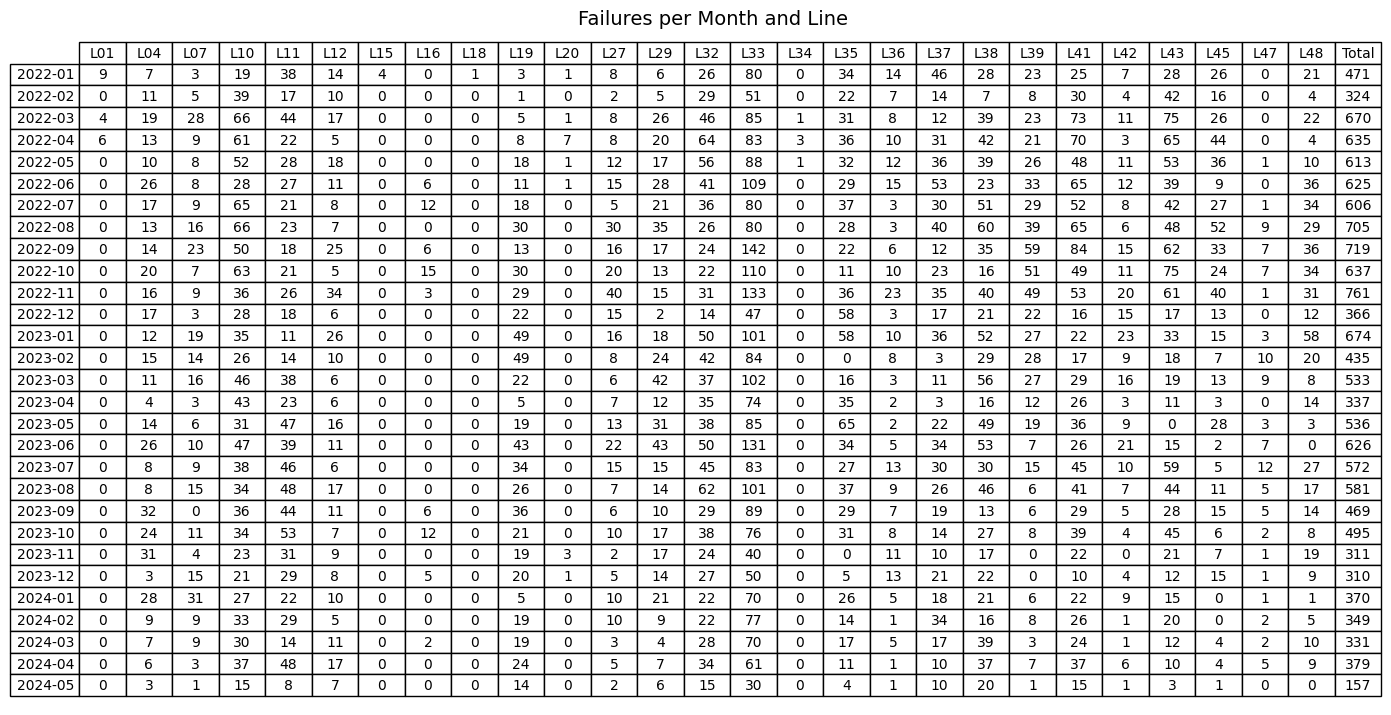

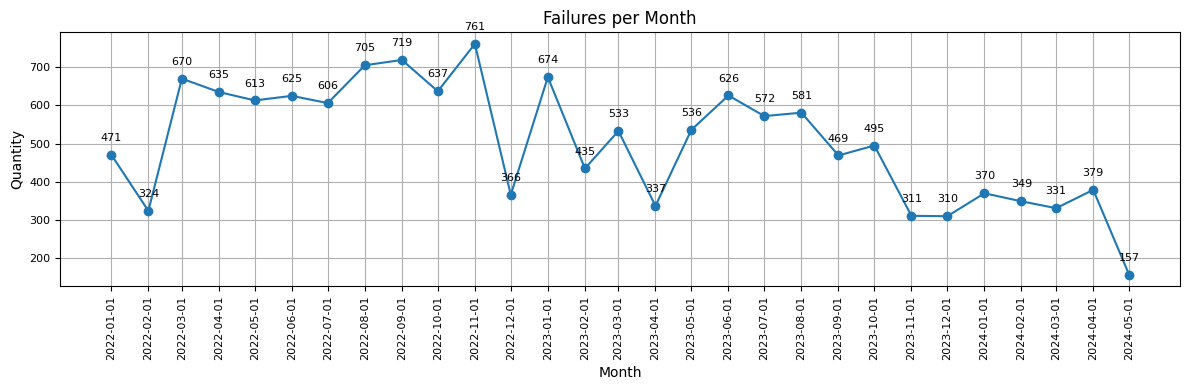

In [16]:
df_cleaned['stop_date'] = pd.to_datetime(df_cleaned['stop_date'])

# Crear una nueva columna para el mes
df_cleaned['month'] = df_cleaned['stop_date'].dt.to_period('M')

# Agrupar por mes y línea y contar las fallas
monthly_line_failures = df_cleaned.groupby(['month', 'line']).size().unstack(fill_value=0)

# Agregar una columna con el total de fallas por mes
monthly_line_failures['Total'] = monthly_line_failures.sum(axis=1)

# Convertir la columna 'month' de Period a datetime para graficar
monthly_line_failures.index = monthly_line_failures.index.to_timestamp()

# Graficar la tabla de fallas por mes y línea
fig, ax = plt.subplots(figsize=(14, 8))

# Crear la tabla
table = ax.table(cellText=monthly_line_failures.values, 
                 rowLabels=monthly_line_failures.index.strftime('%Y-%m'), 
                 colLabels=monthly_line_failures.columns, 
                 cellLoc='center', 
                 loc='center')

# Ajustar tamaño de las celdas
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Ajustar tamaño de las celdas

# Ocultar el gráfico
ax.axis('tight')
ax.axis('off')

# Añadir título con ajuste manual de la posición
plt.suptitle('Failures per Month and Line', fontsize=14)
plt.subplots_adjust(top=0.95)  # Ajustar para reducir el espacio entre el título y la tabla

plt.show()

monthly_failures = df_cleaned.groupby('month').size().reset_index(name='failures_count')

# Convertir la columna 'month' de Period a datetime para graficar
monthly_failures['month'] = monthly_failures['month'].dt.to_timestamp()

plt.figure(figsize=(12, 4))
plt.plot(monthly_failures['month'], monthly_failures['failures_count'], marker='o')

# Añadir etiquetas con los valores en cada punto
for i, row in monthly_failures.iterrows():
    plt.annotate(row['failures_count'], (row['month'], row['failures_count']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Asegurarse de que todos los valores del eje X se muestren
plt.xticks(monthly_failures['month'], rotation=90, fontsize=8)

plt.title('Failures per Month', fontsize=12)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Quantity', fontsize=10)
plt.grid(True)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

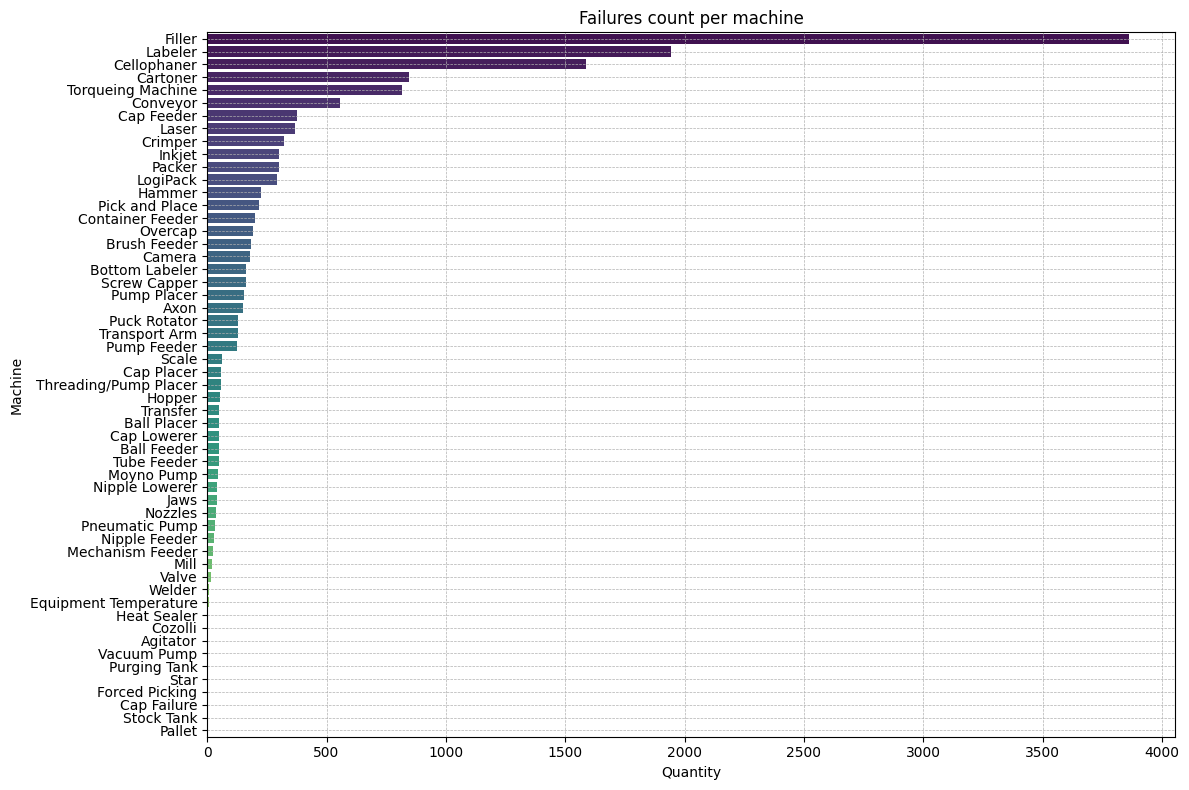

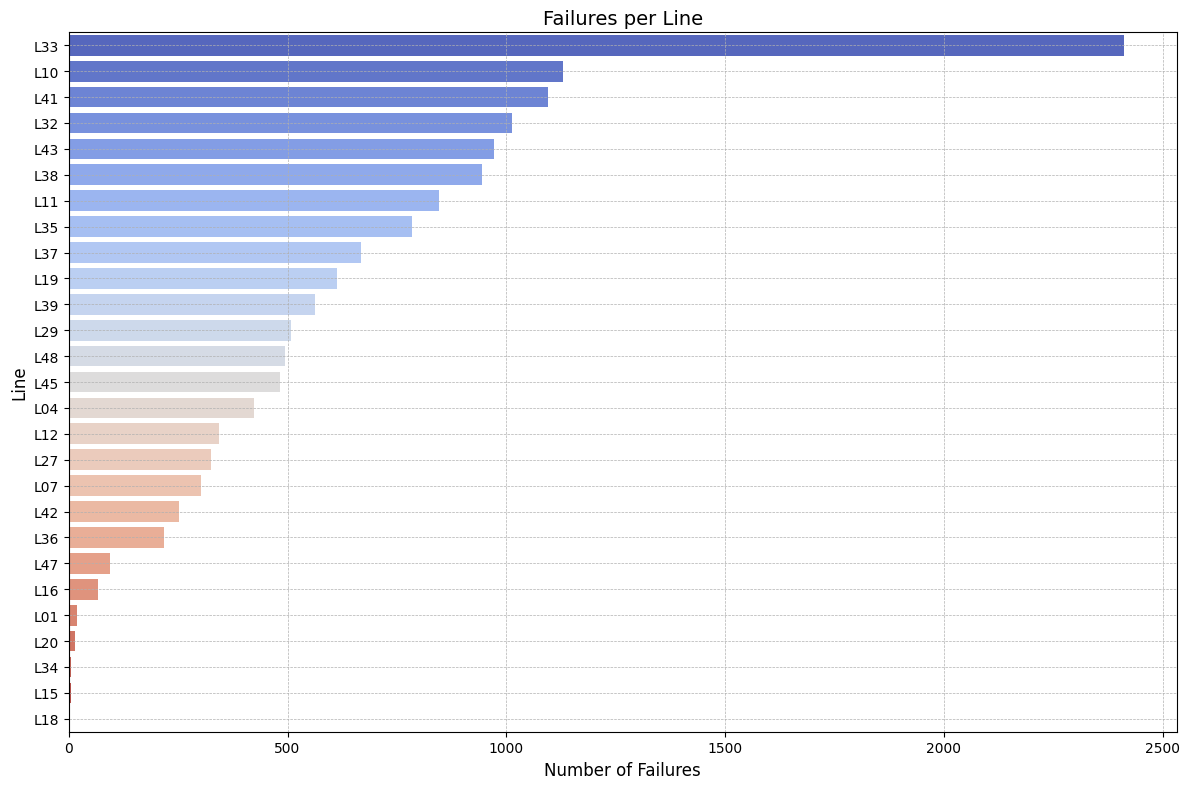

In [17]:
machine_failures = df_cleaned.groupby('machine').size().reset_index(name='failures_count')

# Ordenar por número de fallas
machine_failures = machine_failures.sort_values(by='failures_count', ascending=False)

# Graficar el número de fallas por máquina con barras horizontales
plt.figure(figsize=(12, 8))
sns.barplot(data=machine_failures, x='failures_count', y='machine', palette='viridis')

# Personalización del gráfico
plt.title('Failures count per machine')
plt.xlabel('Quantity')
plt.ylabel('Machine')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

line_failures = df_cleaned.groupby('line').size().reset_index(name='failures_count')

# Ordenar por número de fallas
line_failures = line_failures.sort_values(by='failures_count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=line_failures, x='failures_count', y='line', palette='coolwarm')

# Personalización del gráfico
plt.title('Failures count per line')
plt.xlabel('Quantity')
plt.ylabel('Line')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.title('Failures per Line', fontsize=14)
plt.xlabel('Number of Failures', fontsize=12)
plt.ylabel('Line', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

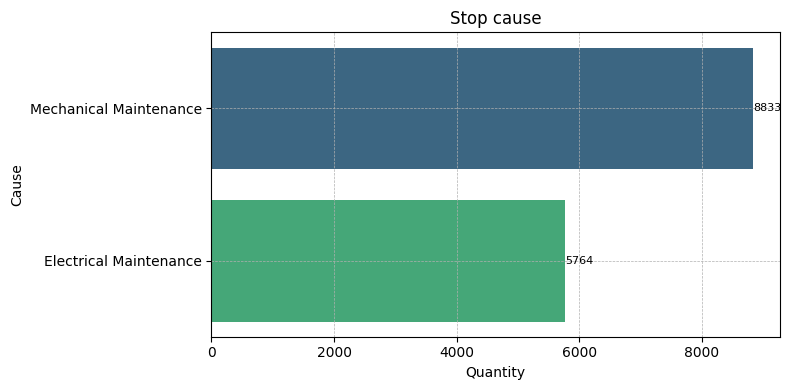

In [18]:
stop_cause = df_cleaned.groupby('stop_cause_description').size().reset_index(name='Quantity')

# Ordenar los datos para mejor visualización
stop_cause = stop_cause.sort_values(by='Quantity', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(8, 4))
bar_plot = sns.barplot(data=stop_cause, x='Quantity', y='stop_cause_description', palette='viridis')

# Personalización del gráfico
plt.title('Stop cause')
plt.xlabel('Quantity')
plt.ylabel('Cause')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Añadir los valores sobre las barras
for bar in bar_plot.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', 
             va='center', ha='left', color='black', fontsize=8)

plt.tight_layout()

# Mostrar el gráfico
plt.show()

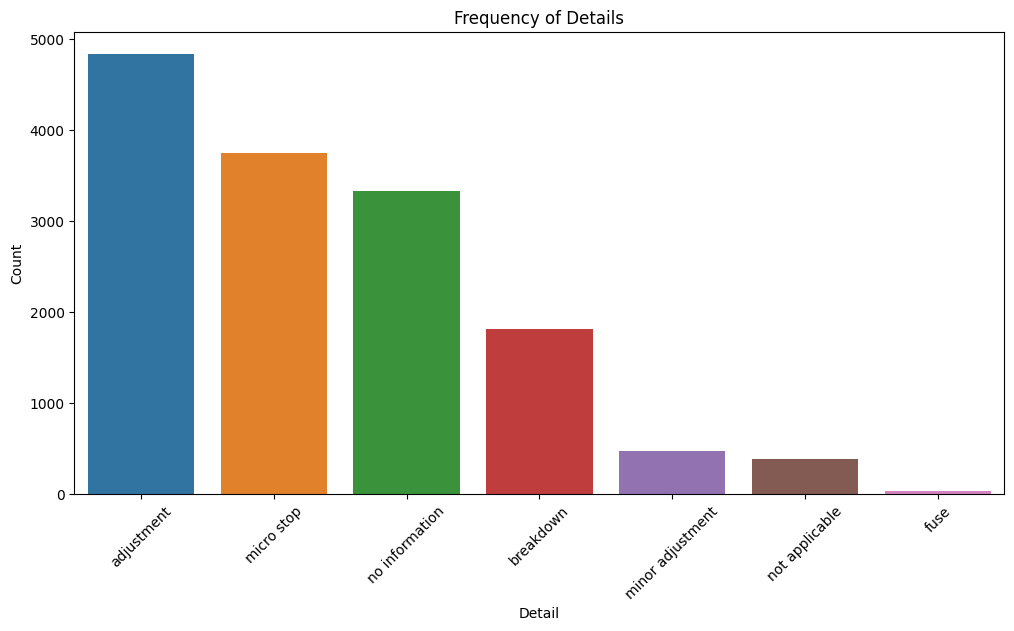

In [19]:
plt.figure(figsize=(12, 6))  # Set the figure size
sns.countplot(data=df_cleaned, x='detail', order=df_cleaned['detail'].value_counts().index)  # Plot the countplot
plt.title('Frequency of Details')  # Set the title
plt.xticks(rotation=45)  # Rotate the x-axis labels
plt.xlabel('Detail')  # Set the x-axis label
plt.ylabel('Count')  # Set the y-axis label
plt.show()  # Show the plot

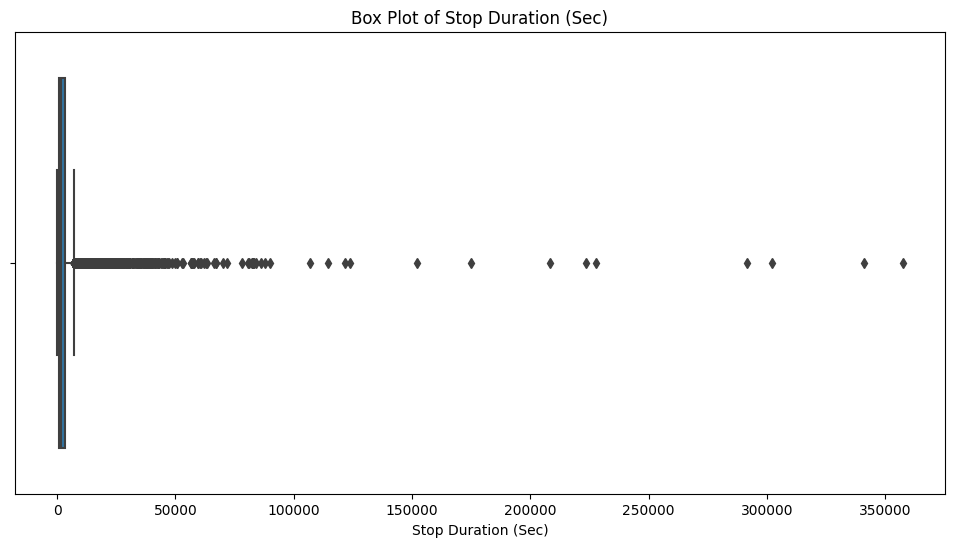

In [20]:
#Box Plot of 'Stop_duration (Sec)'
plt.figure(figsize=(12, 6))  # Set the figure size
sns.boxplot(x=df_cleaned['stop_duration_sec'])  # Plot the boxplot
plt.title('Box Plot of Stop Duration (Sec)')  # Set the title
plt.xlabel('Stop Duration (Sec)')  # Set the x-axis label
plt.show()  # Show the plot

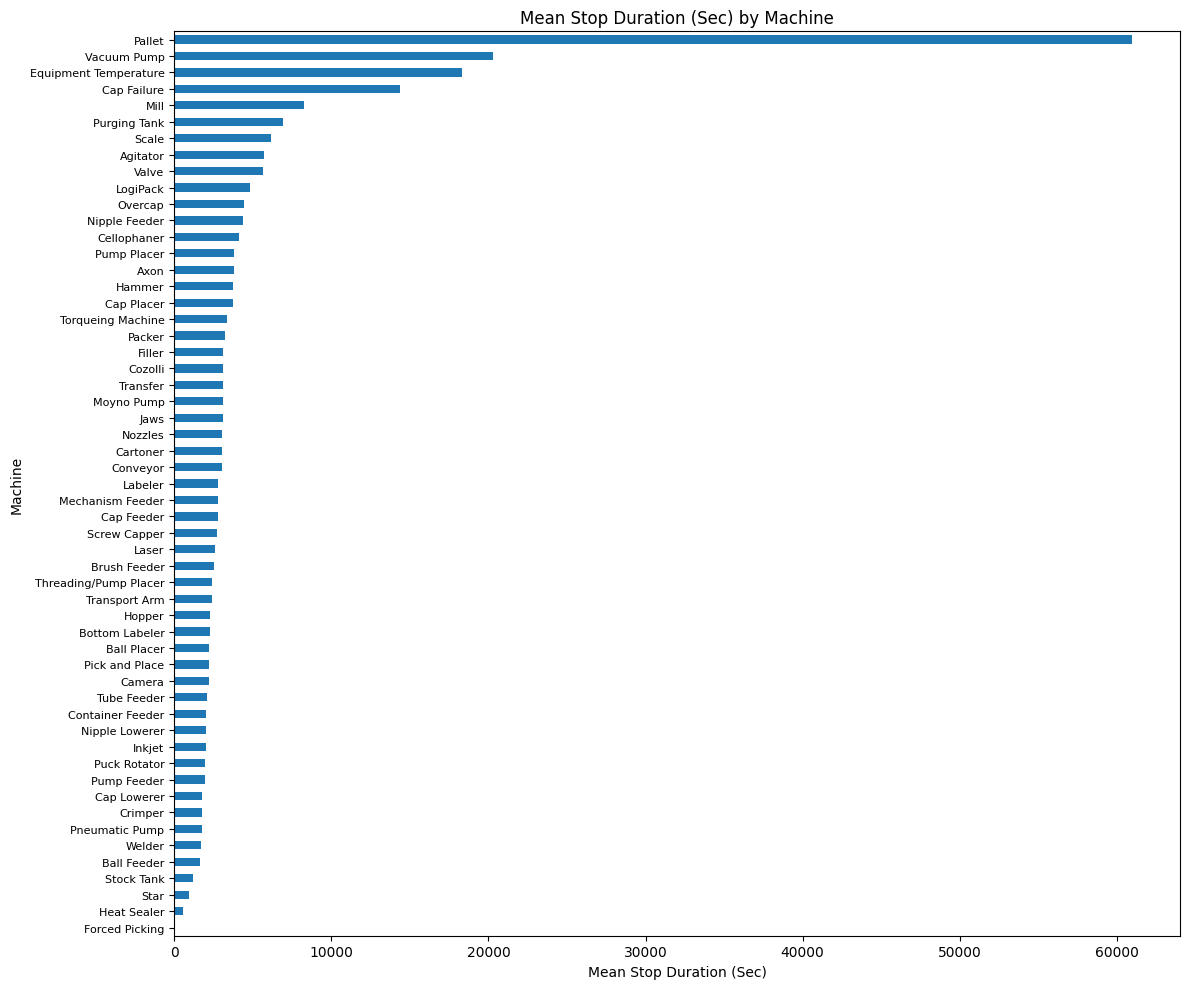

In [21]:
mean_duration_by_machine = df_cleaned.groupby('machine')['stop_duration_sec'].mean().sort_values()

plt.figure(figsize=(12, 10))
# Graficar el diagrama de barras horizontal
mean_duration_by_machine.plot(kind='barh')

# Ajustar el título y etiquetas de los ejes
plt.title('Mean Stop Duration (Sec) by Machine')
plt.xlabel('Mean Stop Duration (Sec)')
plt.ylabel('Machine')

# Ajustar las etiquetas del eje Y
plt.yticks(fontsize=8)  # Reducir el tamaño de la fuente de las etiquetas del eje Y
plt.tight_layout()  # Ajustar automáticamente el espaciado para que las etiquetas se muestren correctamente

# Mostrar el gráfico
plt.show()

In [22]:
mean_duration_by_machine = df_cleaned.groupby('machine')['stop_duration_min'].mean()
failure_count_by_machine = df_cleaned.groupby('machine')['stop_duration_min'].count()
summary_table = pd.DataFrame({
    'Mean Stop Duration (Min)': mean_duration_by_machine,
    'Failure Count': failure_count_by_machine
})
summary_table = summary_table.sort_values(by='Failure Count', ascending=False)
# Mostrar la tabla resultante
print(summary_table)

                       Mean Stop Duration (Min)  Failure Count
machine                                                       
Filler                                  52.2347           3861
Labeler                                 46.5882           1942
Cellophaner                              68.377           1588
Cartoner                                51.2188            847
Torqueing Machine                       55.8509            816
Conveyor                                51.1086            555
Cap Feeder                              46.0237            378
Laser                                   43.3836            370
Crimper                                 29.2421            321
Inkjet                                  33.3349            302
Packer                                  54.1364            299
LogiPack                                80.7197            293
Hammer                                  62.5673            226
Pick and Place                          34.2084        

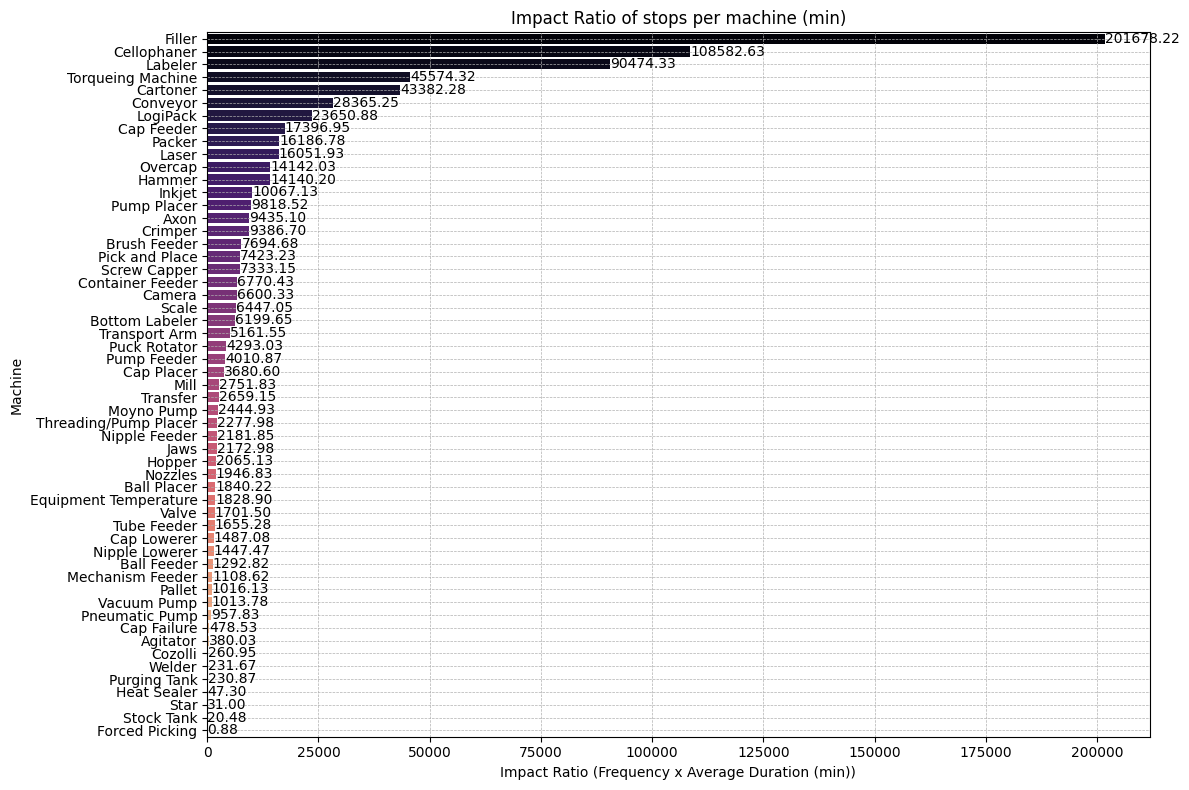

In [23]:
aggregated_data = df_cleaned.groupby('machine').agg(
    Quantity=('machine', 'size'),
    average_duration=('stop_duration_min', 'mean')
).reset_index()

# Calcular el índice de impacto como producto de frecuencia y duración promedio
aggregated_data['impact_factor'] = aggregated_data['Quantity'] * aggregated_data['average_duration']

# Ordenar los datos para mejor visualización
aggregated_data = aggregated_data.sort_values(by='impact_factor', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=aggregated_data, x='impact_factor', y='machine', palette='magma')

# Personalización del gráfico
plt.title('Impact Ratio of stops per machine (min)')
plt.xlabel('Impact Ratio (Frequency x Average Duration (min))')
plt.ylabel('Machine')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Añadir los valores sobre las barras
for bar in bar_plot.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='black', fontsize=10)

plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [24]:
# Agrupar por mes y contar las fallas
from scipy.stats import kendalltau

installation_date = pd.to_datetime('2022-01-01')

# Calcular la antigüedad de la máquina en días desde la fecha de instalación fija
df_cleaned['machine_age_days'] = (df_cleaned['stop_date'] - installation_date).dt.days

# Agrupar por la antigüedad de la máquina en días y contar el número de fallas
failures_by_age = df_cleaned.groupby('machine_age_days').size()

# Realizar la prueba de correlación de Kendall Tau
tau, p_value = kendalltau(failures_by_age.index, failures_by_age.values)

# Mostrar los resultados
print(f"Kendall tau: {tau:.3f}, P-value: {p_value:.3f}")

# Interpretación del resultado
if p_value < 0.05:
    print("The correlation is significant, so we can reject the null hypothesis.")
else:
    print("There is insufficient evidence to reject the null hypothesis.")

Kendall tau: -0.236, P-value: 0.000
The correlation is significant, so we can reject the null hypothesis.


#Null hypothesis 
#(H₀): There is a relationship between the age of the machine and the number of failures ("the older the machine gets, the more it fails").

#Alternative hypothesis 
#(H₁): There is no relationship between the age of the machine and the number of failures.


In [25]:
from scipy.stats import spearmanr

# Calcular la antigüedad de la máquina en días desde la fecha de instalación fija
df_cleaned['machine_age_days'] = (df_cleaned['stop_date'] - installation_date).dt.days

# Calcular la correlación de Spearman entre la antigüedad de la máquina en días y la duración de la parada
rho, p_value = spearmanr(df_cleaned['machine_age_days'], df_cleaned['stop_duration_sec'])
print(f"Spearman rho: {rho:.3f}, P-value: {p_value:.3f}")

# Interpretación
if p_value < 0.05:
    print("The correlation is significant, so we can reject the null hypothesis.")
else:
    print("There is insufficient evidence to reject the null hypothesis.")

Spearman rho: 0.038, P-value: 0.000
The correlation is significant, so we can reject the null hypothesis.


In [26]:
df_cleaned2 = df_cleaned.copy()

# Eliminar las columnas 'cause', 'month' y 'stop_duration_min'
df_cleaned2 = df_cleaned2.drop(columns=['cause', 'month', 'stop_duration_min'])

# Verificar que las columnas se han eliminado correctamente
print(df_cleaned2.columns)

Index(['machine', 'line', 'stop_cause_description', 'stop_date', 'stop_time', 'resolution_date', 'resolution_time', 'stop_duration_sec', 'detail', 'machine_age_days'], dtype='object')


In [27]:
df_cleaned2.shape

(14597, 10)

# Data Preparation

In [28]:
# Convertir fechas a datetime
df_cleaned2['stop_date'] = pd.to_datetime(df_cleaned2['stop_date'])
df_cleaned2['resolution_date'] = pd.to_datetime(df_cleaned2['resolution_date'])

# Codificación de variables categóricas
df_cleaned2['machine'] = LabelEncoder().fit_transform(df_cleaned2['machine'])
df_cleaned2['line'] = LabelEncoder().fit_transform(df_cleaned2['line'])
df_cleaned2['stop_cause_description'] = LabelEncoder().fit_transform(df_cleaned2['stop_cause_description'])
df_cleaned2['detail'] = LabelEncoder().fit_transform(df_cleaned2['detail'])

# Crear una columna objetivo 'failure'
df_cleaned2['failure'] = np.where(df_cleaned2['stop_duration_sec'] > 600, 1, 0)

# Crear característica de tiempo desde la última falla
df_cleaned2['previous_failure_time'] = df_cleaned2.groupby('machine')['stop_date'].shift(1)
df_cleaned2['time_since_last_failure'] = (df_cleaned2['stop_date'] - df_cleaned2['previous_failure_time']).dt.total_seconds()

# Rellenar con 0 para la primera falla de cada máquina
df_cleaned2['time_since_last_failure'] = df_cleaned2['time_since_last_failure'].fillna(0)

# Convertir la columna 'month' de Period a entero si existe
if 'month' in df_cleaned2.columns:
    df_cleaned2['month'] = df_cleaned2['month'].astype(str).str.extract(r'(\d+)').astype(int)

# Eliminar la columna 'failure' de las características (X)
X = df_cleaned2.drop(columns=['stop_date', 'resolution_date', 'stop_time', 'resolution_time', 'previous_failure_time', 'failure'])  
y = df_cleaned2['failure']  # Esta es la columna objetivo

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# FAILURE PREDICTION (Stop Duration)

# Random Forrest

In [29]:
# Entrenamiento del Modelo
model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)
#Include training data and test
# Evaluación del Modelo
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

# Importancia de las características
importances = model.feature_importances_
for i, v in enumerate(importances):
    print(f'Feature: {X.columns[i]}, Score: {v:.5f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       752
           1       1.00      1.00      1.00      2168

    accuracy                           1.00      2920
   macro avg       1.00      1.00      1.00      2920
weighted avg       1.00      1.00      1.00      2920

AUC-ROC: 1.0
Feature: machine, Score: 0.00134
Feature: line, Score: 0.00228
Feature: stop_cause_description, Score: 0.00280
Feature: stop_duration_sec, Score: 0.71667
Feature: detail, Score: 0.27016
Feature: machine_age_days, Score: 0.00553
Feature: time_since_last_failure, Score: 0.00122


In [30]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

print(f'AUC-ROC mean across folds: {cv_scores.mean()}')
print(f'AUC-ROC std across folds: {cv_scores.std()}')

AUC-ROC mean across folds: 0.9999945904410634
AUC-ROC std across folds: 1.0819117873062113e-05


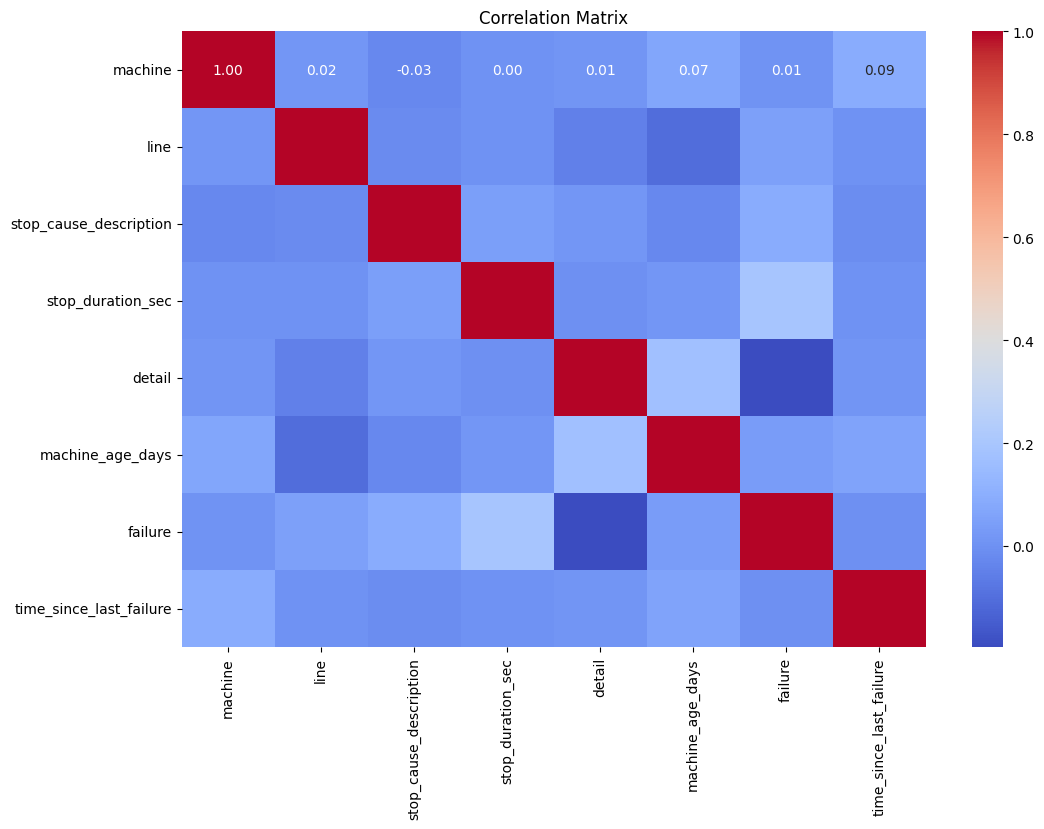

In [31]:
df_numeric = df_cleaned2.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [32]:
df_cleaned3 = df_cleaned.copy()

# Eliminar las columnas 'cause', 'month' y 'stop_duration_min'
df_cleaned3 = df_cleaned3.drop(columns=['cause', 'month', 'stop_duration_min'])

# Verificar que las columnas se han eliminado correctamente
print(df_cleaned3.columns)

Index(['machine', 'line', 'stop_cause_description', 'stop_date', 'stop_time', 'resolution_date', 'resolution_time', 'stop_duration_sec', 'detail', 'machine_age_days'], dtype='object')


In [33]:
df_l33 = df_cleaned3[df_cleaned3['line'] == 'L33']

# Crear un rango de fechas
date_range = pd.date_range(start='2022-01-01', end='2024-05-31', freq='D')

# Crear un DataFrame con todas las combinaciones posibles de máquina y fecha solo para L33
machines = df_l33['machine'].unique()
line = ['L33']  # Solo estamos interesados en la línea L33

full_combinations = pd.MultiIndex.from_product([machines, line, date_range], names=['machine', 'line', 'date'])
full_df = pd.DataFrame(index=full_combinations).reset_index()

# Unir el DataFrame original filtrado con el DataFrame completo de L33
df_complete_l33 = pd.merge(full_df, df_l33, how='left', left_on=['machine', 'line', 'date'], right_on=['machine', 'line', 'stop_date'])

# Crear la columna 'failure' y rellenarla con 1 si hay una falla (es decir, si 'stop_date' no es NaN) y 0 en caso contrario
df_complete_l33['failure'] = df_complete_l33['stop_date'].notna().astype(int)

# Rellenar otras columnas NaN si es necesario
df_complete_l33['stop_cause_description'] = df_complete_l33['stop_cause_description'].fillna('No Failure')
df_complete_l33['stop_duration_sec'] = df_complete_l33['stop_duration_sec'].fillna(0)
df_complete_l33['detail'] = df_complete_l33['detail'].fillna('No Failure')

# Llenar valores faltantes en las fechas de resolución
df_complete_l33['resolution_date'] = df_complete_l33['resolution_date'].fillna(df_complete_l33['date'])

# Ordenar el DataFrame final
df_complete_l33 = df_complete_l33.sort_values(by=['machine', 'date'])

# Verificar las primeras filas del DataFrame resultante
print("Primeros registros de df_complete_l33:", df_complete_l33.head())

# Guardar el DataFrame resultante en un archivo Excel para revisión
df_complete_l33.to_excel('balanced_failure_data_l33.xlsx', index=False)

Primeros registros de df_complete_l33:           machine line       date stop_cause_description  ... stop_duration_sec      detail machine_age_days failure
8866  Ball Feeder  L33 2022-01-01             No Failure  ...                 0  No Failure              NaN       0
8867  Ball Feeder  L33 2022-01-02             No Failure  ...                 0  No Failure              NaN       0
8868  Ball Feeder  L33 2022-01-03             No Failure  ...                 0  No Failure              NaN       0
8869  Ball Feeder  L33 2022-01-04             No Failure  ...                 0  No Failure              NaN       0
8870  Ball Feeder  L33 2022-01-05             No Failure  ...                 0  No Failure              NaN       0

[5 rows x 12 columns]


In [34]:
#Balance Data in this point (Look for technique)

In [35]:
#df_complete_l33.shape
failure_counts = df_complete_l33['failure'].value_counts()
failure_counts

failure
0    11140
1     2274
Name: count, dtype: int64

In [36]:
import pickle
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Convertir fechas a datetime
df_complete_l33['stop_date'] = pd.to_datetime(df_complete_l33['stop_date'])
df_complete_l33['resolution_date'] = pd.to_datetime(df_complete_l33['resolution_date'])

# Codificación de variables categóricas y guardar LabelEncoders
machine_encoder = LabelEncoder()
line_encoder = LabelEncoder()
stop_cause_description_encoder = LabelEncoder()
detail_encoder = LabelEncoder()

df_complete_l33['machine'] = machine_encoder.fit_transform(df_complete_l33['machine'])
df_complete_l33['line'] = line_encoder.fit_transform(df_complete_l33['line'])
df_complete_l33['stop_cause_description'] = stop_cause_description_encoder.fit_transform(df_complete_l33['stop_cause_description'])
df_complete_l33['detail'] = detail_encoder.fit_transform(df_complete_l33['detail'])

# Guardar los LabelEncoders usando pickle
with open('machine_encoder.pkl', 'wb') as f:
    pickle.dump(machine_encoder, f)

with open('line_encoder.pkl', 'wb') as f:
    pickle.dump(line_encoder, f)

with open('stop_cause_description_encoder.pkl', 'wb') as f:
    pickle.dump(stop_cause_description_encoder, f)

with open('detail_encoder.pkl', 'wb') as f:
    pickle.dump(detail_encoder, f)

# Crear una columna objetivo 'failure'
df_complete_l33['failure'] = np.where(df_complete_l33['stop_duration_sec'] > 600, 1, 0)

# Crear característica de tiempo desde la última falla
df_complete_l33['previous_failure_time'] = df_complete_l33.groupby('machine')['stop_date'].shift(1)
df_complete_l33['time_since_last_failure'] = (df_complete_l33['stop_date'] - df_complete_l33['previous_failure_time']).dt.total_seconds()

# Rellenar con 0 para la primera falla de cada máquina
df_complete_l33['time_since_last_failure'] = df_complete_l33['time_since_last_failure'].fillna(0)

# Convertir la columna 'month' de Period a entero si existe
if 'month' in df_complete_l33.columns:
    df_complete_l33['month'] = df_complete_l33['month'].astype(str).str.extract(r'(\d+)').astype(int)

# Eliminar todas las columnas de tipo datetime y otras columnas no necesarias
X = df_complete_l33.drop(columns=['stop_date', 'resolution_date', 'stop_time', 'resolution_time', 'previous_failure_time', 'failure'])

# Asegurarse de que no haya columnas datetime en X
X = X.select_dtypes(exclude=['datetime64'])

# Imputar valores faltantes en X
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Preparar la variable objetivo
y = df_complete_l33['failure']  # Esta es la columna objetivo

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Entrenamiento del Modelo con datos balanceados y class_weight='balanced'
model = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# Evaluación del Modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

# Importancia de las características
importances = model.feature_importances_
for i, v in enumerate(importances):
    print(f'Feature: {X.columns[i]}, Score: {v:.5f}')


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2374
           1       1.00      1.00      1.00       309

    accuracy                           1.00      2683
   macro avg       1.00      1.00      1.00      2683
weighted avg       1.00      1.00      1.00      2683

AUC-ROC: 1.0
Feature: machine, Score: 0.00498
Feature: line, Score: 0.00000
Feature: stop_cause_description, Score: 0.22701
Feature: stop_duration_sec, Score: 0.42055
Feature: detail, Score: 0.26385
Feature: machine_age_days, Score: 0.07146
Feature: time_since_last_failure, Score: 0.01216


In [37]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificar el balance de clases después de aplicar SMOTE
print("Distribución de clases en el conjunto de entrenamiento después de SMOTE:")
print(y_train_resampled.value_counts())

Distribución de clases en el conjunto de entrenamiento después de SMOTE:
failure
0    9451
1    9451
Name: count, dtype: int64


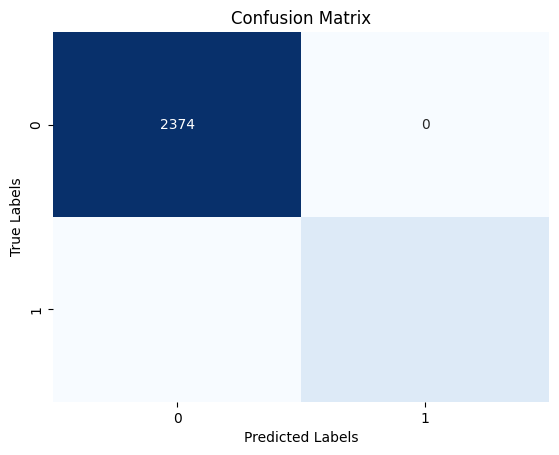

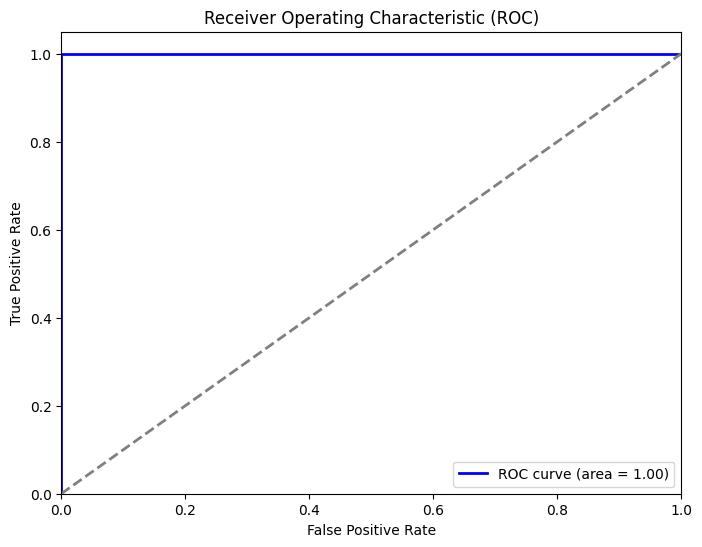

In [38]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [39]:
#df_complete_l33.shape
#df_complete.columns
df_complete_l33['failure'].unique()

array([0, 1])

# Logistic regression

In [40]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_resampled, y_train_resampled)

# Predicciones con el modelo de Regresión Logística en el conjunto de prueba original
y_pred_logistic = logistic_model.predict(X_test)
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo de Regresión Logística
print("Regresión Logística - Classification Report")
print(classification_report(y_test, y_pred_logistic))
print(f'AUC-ROC: {roc_auc_score(y_test, y_prob_logistic)}')

Regresión Logística - Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2374
           1       0.94      0.99      0.96       309

    accuracy                           0.99      2683
   macro avg       0.97      0.99      0.98      2683
weighted avg       0.99      0.99      0.99      2683

AUC-ROC: 0.9998036986447028


# DECISION TREE

Árbol de Decisión - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2374
           1       1.00      1.00      1.00       309

    accuracy                           1.00      2683
   macro avg       1.00      1.00      1.00      2683
weighted avg       1.00      1.00      1.00      2683

AUC-ROC: 0.9983818770226538


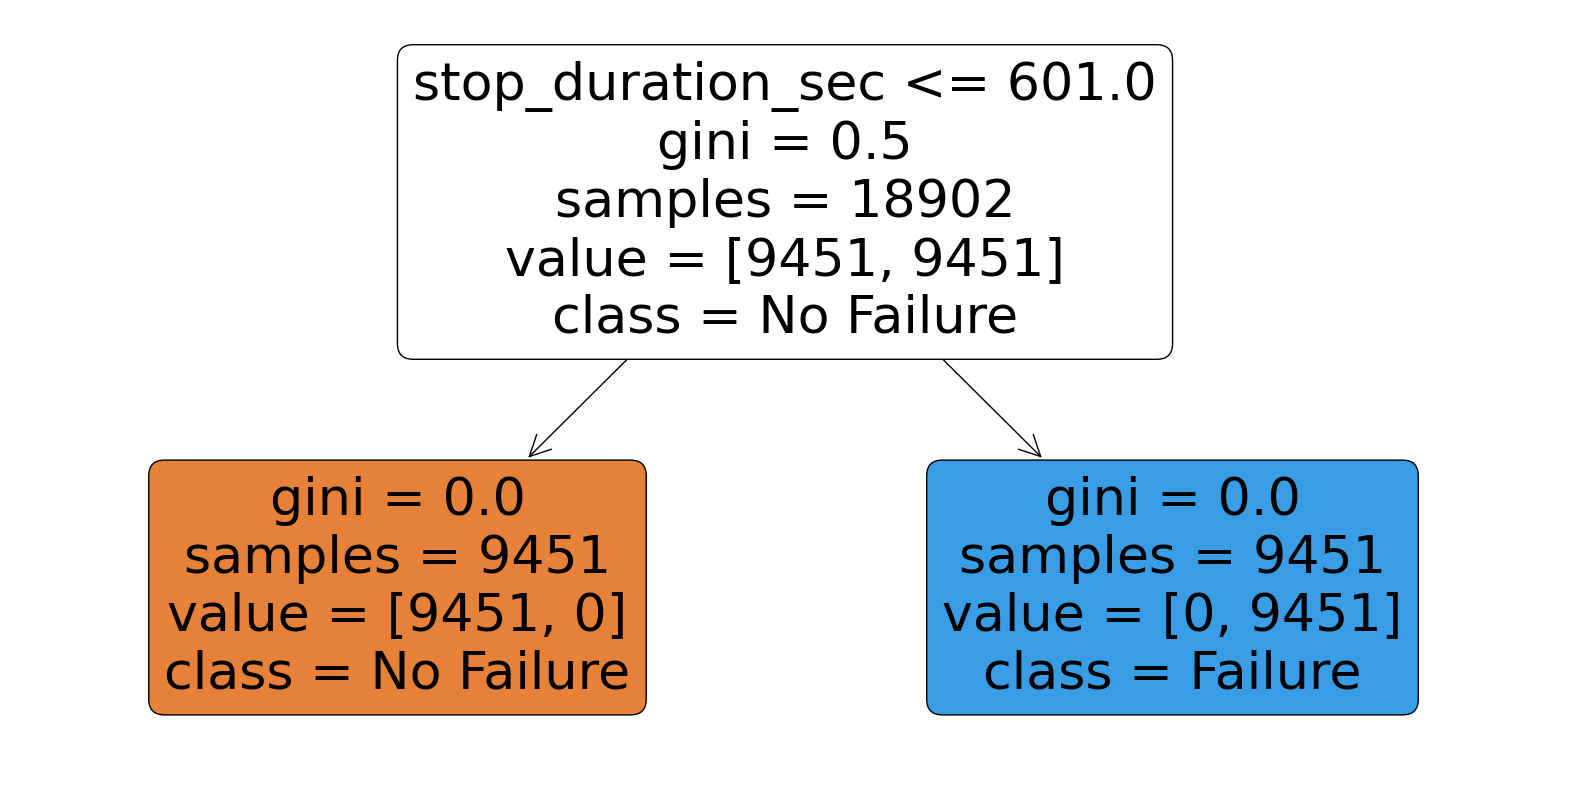

In [41]:
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_resampled, y_train_resampled)

# Predicciones con el modelo de Árbol de Decisión en el conjunto de prueba original
y_pred_tree = decision_tree_model.predict(X_test)
y_prob_tree = decision_tree_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo de Árbol de Decisión
print("Árbol de Decisión - Classification Report")
print(classification_report(y_test, y_pred_tree))
print(f'AUC-ROC: {roc_auc_score(y_test, y_prob_tree)}')

# Visualizar el árbol de decisión
plt.figure(figsize=(20, 10))
tree.plot_tree(decision_tree_model, 
               filled=True, 
               feature_names=X.columns.tolist(),  # Convertir Index a lista
               class_names=['No Failure', 'Failure'], 
               rounded=True)
plt.show()

# Support Vector Machine

In [42]:
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

# Predicciones con el modelo de SVM en el conjunto de prueba original
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo de SVM
print("Support Vector Machine (SVM) - Classification Report")
print(classification_report(y_test, y_pred_svm))
print(f'AUC-ROC: {roc_auc_score(y_test, y_prob_svm)}')

Support Vector Machine (SVM) - Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2374
           1       0.88      1.00      0.94       309

    accuracy                           0.98      2683
   macro avg       0.94      0.99      0.96      2683
weighted avg       0.99      0.98      0.98      2683

AUC-ROC: 0.9988998944880215


# NEURONAL NETWORK

In [43]:
model_nn = Sequential()
model_nn.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))  # Capa de entrada con 64 neuronas y activación ReLU
model_nn.add(Dense(32, activation='relu'))  # Capa oculta con 32 neuronas y activación ReLU
model_nn.add(Dense(1, activation='sigmoid'))  # Capa de salida con 1 neurona y activación sigmoide para clasificación binaria

# Compilar la Red Neuronal
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Añadir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar la Red Neuronal con datos balanceados
history = model_nn.fit(X_train_resampled, y_train_resampled, 
                       epochs=100, 
                       batch_size=100, 
                       validation_split=0.2, 
                       verbose=1, 
                       callbacks=[early_stopping])  # Añadir Early Stopping

# Predicciones con la Red Neuronal en el conjunto de prueba original
y_pred_nn_prob = model_nn.predict(X_test)
y_pred_nn = np.round(y_pred_nn_prob)

# Evaluar el Modelo
print("Red Neuronal - Classification Report")
print(classification_report(y_test, y_pred_nn))
print(f'AUC-ROC: {roc_auc_score(y_test, y_pred_nn_prob)}')

Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8509 - loss: 13.8676 - val_accuracy: 0.9915 - val_loss: 0.0496
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9794 - loss: 3.5812 - val_accuracy: 0.9981 - val_loss: 0.0070
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9743 - loss: 3.0021 - val_accuracy: 0.9995 - val_loss: 0.0019
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 4.7769 - val_accuracy: 0.9966 - val_loss: 0.0110
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 1.8969 - val_accuracy: 0.8812 - val_loss: 30.5095
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9765 - loss: 2.7271 - val_accuracy: 0.9913 - val_loss: 0.0236
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9781 - loss: 3.9436 - val_accuracy: 0.9638 - val_loss: 0.0790
Epoch 8/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 3.5483 - val_ac

In [44]:
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC-ROC": []
}

# Función para calcular y almacenar las métricas
def store_metrics(model_name, y_true, y_pred, y_prob):
    results["Model"].append(model_name)
    results["Accuracy"].append(accuracy_score(y_true, y_pred))
    results["Precision"].append(precision_score(y_true, y_pred))
    results["Recall"].append(recall_score(y_true, y_pred))
    results["F1-Score"].append(f1_score(y_true, y_pred))
    results["AUC-ROC"].append(roc_auc_score(y_true, y_prob))

# Random Forest
store_metrics("Random Forest", y_test, y_pred, y_prob)

# Logistic Regression
store_metrics("Logistic Regression", y_test, y_pred_logistic, y_prob_logistic)

# Decision Tree
store_metrics("Decision Tree", y_test, y_pred_tree, y_prob_tree)

# SVM
store_metrics("SVM", y_test, y_pred_svm, y_prob_svm)

# Neural Network
store_metrics("Neural Network", y_test, y_pred_nn, y_pred_nn_prob)

# Convertir los resultados a un DataFrame para facilitar la visualización
results_df = pd.DataFrame(results)

# Mostrar los resultados comparativos
print(results_df)

                 Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
0        Random Forest         1          1        1         1        1
1  Logistic Regression  0.991428    0.93865 0.990291   0.96378 0.999804
2        Decision Tree  0.999627          1 0.996764  0.998379 0.998382
3                  SVM  0.984346   0.880342        1  0.936364   0.9989
4       Neural Network  0.973537   0.813158        1  0.896952 0.994716


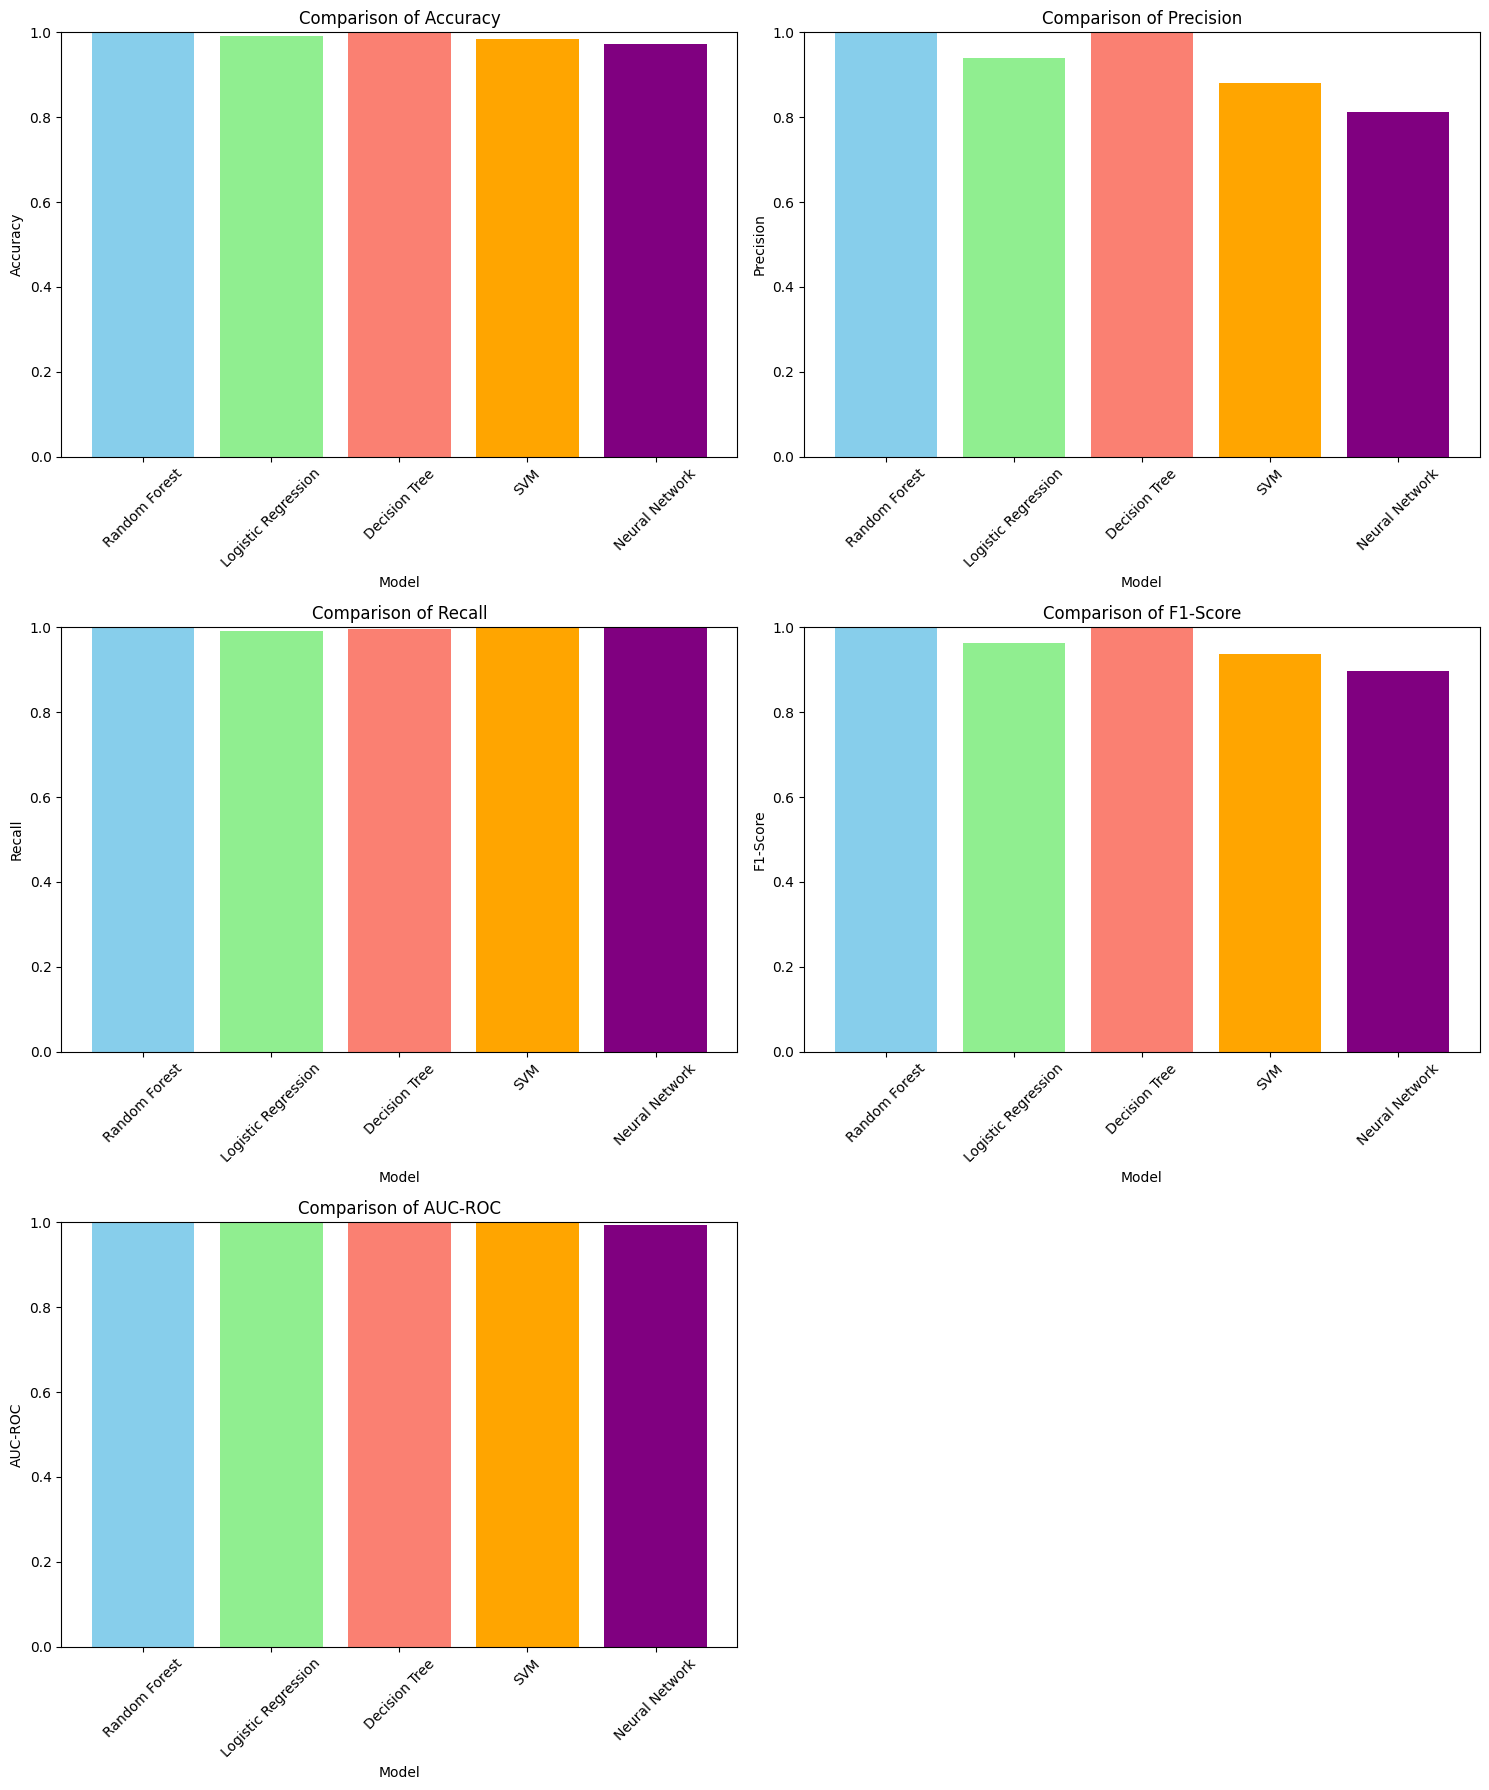

In [45]:
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'purple']

# Definir las métricas
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]

# Crear subplots (3 filas, 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.ravel()  # Para aplanar la matriz de ejes y poder iterar fácilmente

# Iterar sobre las métricas y gráficos
for i, metric in enumerate(metrics):
    axes[i].bar(results_df["Model"], results_df[metric], color=colors)
    axes[i].set_title(f'Comparison of {metric}')
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, 1)  # Asegura que el rango esté entre 0 y 1 para todas las métricas
    axes[i].tick_params(axis='x', rotation=45)  # Rotar las etiquetas en el eje x para evitar superposición

# Eliminar el sexto subplot vacío si no es necesario
if len(metrics) < len(axes):
    fig.delaxes(axes[-1])

# Ajustar la disposición y mostrar el gráfico
plt.tight_layout()
plt.show()

In [46]:
#df_complete_l33.shape
df_complete_l33.sort_values(by=['machine', 'stop_date'], inplace=True)  # Sort the DataFrame by 'Machine' and 'Stop_date'
df_complete_l33['uptime'] = df_complete_l33.groupby('machine')['stop_date'].diff().dt.total_seconds() / 60  # Convert to minutes
df_complete_l33['uptime'].fillna(0, inplace=True)
df_complete_l33[['machine', 'stop_date', 'uptime']].head(10)

,machine,stop_date,uptime
8877,0,2022-01-12,0
8889,0,2022-01-24,17280
8891,0,2022-01-26,2880
8981,0,2022-04-26,129600
9040,0,2022-06-24,84960
9050,0,2022-07-04,14400
9141,0,2022-10-03,131040
9142,0,2022-10-03,0
9145,0,2022-10-06,4320
9146,0,2022-10-06,0


# FAILURE PREDICTION (Uptime)

# Random Forrest

In [47]:
y_train_new = df_complete_l33['failure']
class_counts = y_train_new.value_counts()
print(class_counts)

failure
0    11825
1     1589
Name: count, dtype: int64


Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     11825
           1       0.55      0.78      0.64      1589

    accuracy                           0.90     13414
   macro avg       0.76      0.85      0.79     13414
weighted avg       0.92      0.90      0.91     13414

AUC-ROC: 0.9229


<Figure size 400x300 with 0 Axes>

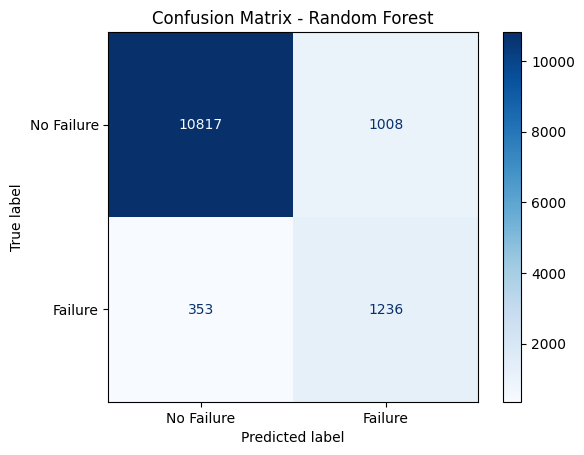

In [48]:
X_train_new = df_complete_l33[['machine', 'uptime']]
y_train_new = df_complete_l33['failure']

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_new, y_train_new)

# Entrenar un nuevo modelo con los datos balanceados
model_new = RandomForestClassifier(n_estimators=1000, random_state=42)
model_new.fit(X_train_resampled, y_train_resampled)

# Usar este nuevo modelo para predecir en el conjunto original
y_pred_prob = model_new.predict_proba(X_train_new)[:, 1]  # Obtener la probabilidad de la clase 1 (falla)
y_pred_class = (y_pred_prob >= 0.5).astype(int)  # Clasificar en 0 o 1 basado en la probabilidad

# Agregar las predicciones al DataFrame original
df_complete_l33['predicted_failure'] = y_pred_class
df_complete_l33['predicted_failure_probability'] = y_pred_prob

# Evaluar el modelo utilizando AUC-ROC en el conjunto original
roc_auc = roc_auc_score(y_train_new, y_pred_prob)

# Calcular y mostrar las métricas de evaluación
print("Random Forest - Classification Report")
print(classification_report(y_train_new, y_pred_class))
print(f"AUC-ROC: {roc_auc:.4f}")

cm = confusion_matrix(df_complete_l33['failure'], df_complete_l33['predicted_failure'])

plt.figure(figsize=(4, 3))
# Crear y graficar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [49]:
print(df_complete_l33[['machine', 'stop_date', 'uptime', 'predicted_failure', 'predicted_failure_probability']])

      machine  stop_date  uptime  predicted_failure  predicted_failure_probability
8877        0 2022-01-12       0                  0                      0.0813332
8889        0 2022-01-24   17280                  1                              1
8891        0 2022-01-26    2880                  1                       0.997071
8981        0 2022-04-26  129600                  1                              1
9040        0 2022-06-24   84960                  0                          0.373
...       ...        ...     ...                ...                            ...
878        13        NaT       0                  0                              0
879        13        NaT       0                  0                              0
880        13        NaT       0                  0                              0
881        13        NaT       0                  0                              0
882        13        NaT       0                  0                              0

[13

In [50]:
df_complete_l33.shape

(13414, 17)

In [51]:
with open('machine_encoder.pkl', 'rb') as f:
    machine_encoder = pickle.load(f)

# Decodificar la columna 'machine'
df_complete_l33['machine_decoded'] = machine_encoder.inverse_transform(df_complete_l33['machine'])

# Verificar el resultado
print(df_complete_l33[['machine_decoded', 'machine', 'stop_date', 'uptime', 'predicted_failure', 'failure', 'predicted_failure_probability']])

     machine_decoded  machine  stop_date  uptime  predicted_failure  failure  predicted_failure_probability
8877     Ball Feeder        0 2022-01-12       0                  0        0                      0.0813332
8889     Ball Feeder        0 2022-01-24   17280                  1        1                              1
8891     Ball Feeder        0 2022-01-26    2880                  1        1                       0.997071
8981     Ball Feeder        0 2022-04-26  129600                  1        1                              1
9040     Ball Feeder        0 2022-06-24   84960                  0        0                          0.373
...              ...      ...        ...     ...                ...      ...                            ...
878            Valve       13        NaT       0                  0        0                              0
879            Valve       13        NaT       0                  0        0                              0
880            Valve       1

In [52]:
differences = (df_complete_l33['failure'] != df_complete_l33['predicted_failure']).sum()

print(f"Number of cases where failure and predicted_failure are different: {differences}")

Number of cases where failure and predicted_failure are different: 1361


In [53]:
df_differences = df_complete_l33[df_complete_l33['failure'] != df_complete_l33['predicted_failure']]

# Seleccionar las columnas que te interesan
df_differences_selected = df_differences[['machine_decoded', 'uptime','stop_date','predicted_failure', 'failure', 'predicted_failure_probability']]

# Mostrar la tabla resultante
print(df_differences_selected)

# Si prefieres guardarla en un archivo Excel o CSV, puedes hacer lo siguiente:
df_differences_selected.to_excel('diference_failure_predicted.xlsx', index=False)

         machine_decoded  uptime  stop_date  predicted_failure  failure  predicted_failure_probability
9142         Ball Feeder       0 2022-10-03                  0        1                      0.0813332
9146         Ball Feeder       0 2022-10-06                  0        1                      0.0813332
9160         Ball Feeder       0 2022-10-18                  0        1                      0.0813332
9177         Ball Feeder       0 2022-11-02                  0        1                      0.0813332
9221         Ball Feeder       0 2022-12-15                  0        1                      0.0813332
...                  ...     ...        ...                ...      ...                            ...
10652  Torqueing Machine    4320 2024-02-19                  1        0                       0.974223
10653  Torqueing Machine       0 2024-02-19                  0        1                       0.462376
10660  Torqueing Machine    8640 2024-02-26                  1        0  

# Logistic Regression

Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     11825
           1       0.70      0.52      0.60      1589

    accuracy                           0.92     13414
   macro avg       0.82      0.75      0.78     13414
weighted avg       0.91      0.92      0.91     13414

AUC-ROC: 0.7480


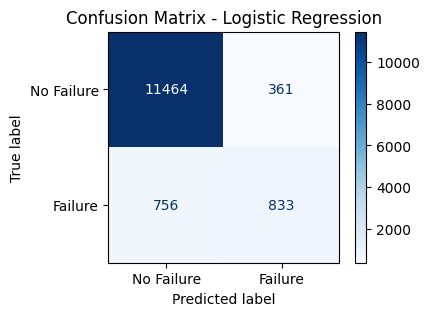

In [54]:
model_logistic = LogisticRegression(random_state=42)
model_logistic.fit(X_train_resampled, y_train_resampled)

# Usar este nuevo modelo para predecir en el conjunto original
y_pred_prob_logistic = model_logistic.predict_proba(X_train_new)[:, 1]  # Obtener la probabilidad de la clase 1 (falla)
y_pred_class_logistic = (y_pred_prob_logistic >= 0.5).astype(int)  # Clasificar en 0 o 1 basado en la probabilidad

# Agregar las predicciones al DataFrame original
df_complete_l33['predicted_failure_logistic'] = y_pred_class_logistic
df_complete_l33['predicted_failure_probability_logistic'] = y_pred_prob_logistic

# Evaluar el modelo utilizando AUC-ROC en el conjunto original
roc_auc_logistic = roc_auc_score(y_train_new, y_pred_prob_logistic)

# Calcular y mostrar las métricas de evaluación
print("Logistic Regression - Classification Report")
print(classification_report(y_train_new, y_pred_class_logistic))
print(f"AUC-ROC: {roc_auc_logistic:.4f}")

# Calcular la matriz de confusión
cm_logistic = confusion_matrix(df_complete_l33['failure'], df_complete_l33['predicted_failure_logistic'])

# Ajustar el tamaño de la figura
plt.figure(figsize=(4, 3))

# Crear y graficar la matriz de confusión
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=['No Failure', 'Failure'])
disp_logistic.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Asegurar que la gráfica se ajuste al tamaño de la figura

# Añadir el título
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Decision Tree

Decision Tree - Classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     11825
           1       0.55      0.78      0.65      1589

    accuracy                           0.90     13414
   macro avg       0.76      0.85      0.79     13414
weighted avg       0.92      0.90      0.91     13414

AUC-ROC: 0.9236


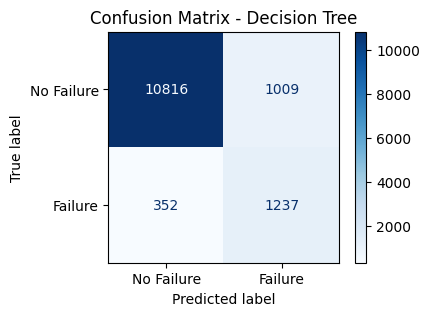

In [55]:
model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(X_train_resampled, y_train_resampled)

# Usar este nuevo modelo para predecir en el conjunto original
y_pred_prob_tree = model_tree.predict_proba(X_train_new)[:, 1]  # Obtener la probabilidad de la clase 1 (falla)
y_pred_class_tree = (y_pred_prob_tree >= 0.5).astype(int)  # Clasificar en 0 o 1 basado en la probabilidad

# Agregar las predicciones al DataFrame original
df_complete_l33['predicted_failure_tree'] = y_pred_class_tree
df_complete_l33['predicted_failure_probability_tree'] = y_pred_prob_tree

# Evaluar el modelo utilizando AUC-ROC en el conjunto original
roc_auc_tree = roc_auc_score(y_train_new, y_pred_prob_tree)

# Calcular y mostrar las métricas de evaluación
print("Decision Tree - Classification Report")
print(classification_report(y_train_new, y_pred_class_tree))
print(f"AUC-ROC: {roc_auc_tree:.4f}")

# Calcular la matriz de confusión
cm_tree = confusion_matrix(df_complete_l33['failure'], df_complete_l33['predicted_failure_tree'])

# Ajustar el tamaño de la figura
plt.figure(figsize=(4, 3))

# Crear y graficar la matriz de confusión
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['No Failure', 'Failure'])
disp_tree.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Asegurar que la gráfica se ajuste al tamaño de la figura

# Añadir el título
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Support Vector Machine

Support Vector Machine (SVM) - Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     11825
           1       0.70      0.52      0.60      1589

    accuracy                           0.92     13414
   macro avg       0.82      0.75      0.78     13414
weighted avg       0.91      0.92      0.91     13414

AUC-ROC: 0.7454


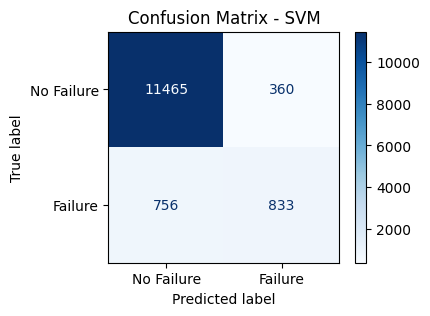

In [56]:
model_svm = SVC(probability=True, random_state=42)
model_svm.fit(X_train_resampled, y_train_resampled)

# Usar este nuevo modelo para predecir en el conjunto original
y_pred_prob_svm = model_svm.predict_proba(X_train_new)[:, 1]  # Obtener la probabilidad de la clase 1 (falla)
y_pred_class_svm = (y_pred_prob_svm >= 0.5).astype(int)  # Clasificar en 0 o 1 basado en la probabilidad

# Agregar las predicciones al DataFrame original
df_complete_l33['predicted_failure_svm'] = y_pred_class_svm
df_complete_l33['predicted_failure_probability_svm'] = y_pred_prob_svm

# Evaluar el modelo utilizando AUC-ROC en el conjunto original
roc_auc_svm = roc_auc_score(y_train_new, y_pred_prob_svm)

# Calcular y mostrar las métricas de evaluación
print("Support Vector Machine (SVM) - Classification Report")
print(classification_report(y_train_new, y_pred_class_svm))
print(f"AUC-ROC: {roc_auc_svm:.4f}")

# Calcular la matriz de confusión
cm_svm = confusion_matrix(df_complete_l33['failure'], df_complete_l33['predicted_failure_svm'])

# Ajustar el tamaño de la figura
plt.figure(figsize=(4, 3))

# Crear y graficar la matriz de confusión
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['No Failure', 'Failure'])
disp_svm.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Asegurar que la gráfica se ajuste al tamaño de la figura

# Añadir el título
plt.title("Confusion Matrix - SVM")
plt.show()

# NEURONAL NETWORK

Epoch 1/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7665 - loss: 6.4408 - val_accuracy: 0.5317 - val_loss: 0.4542
Epoch 2/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7803 - loss: 4.2098 - val_accuracy: 0.0000e+00 - val_loss: 17.5510
Epoch 3/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7744 - loss: 3.0632 - val_accuracy: 0.5317 - val_loss: 0.6906
Epoch 4/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7909 - loss: 6.9668 - val_accuracy: 0.5317 - val_loss: 0.5784
Epoch 5/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7840 - loss: 2.4756 - val_accuracy: 0.5317 - val_loss: 0.6133
Epoch 6/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7860 - loss: 3.8977 - val_accuracy: 0.5317 - val_loss: 0.5621
Epoch 7/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7966 - loss: 2.9509 - val_accuracy: 0.5317 - val_loss: 0.5831
Epoch 8/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8021 - loss: 2.2411 - val

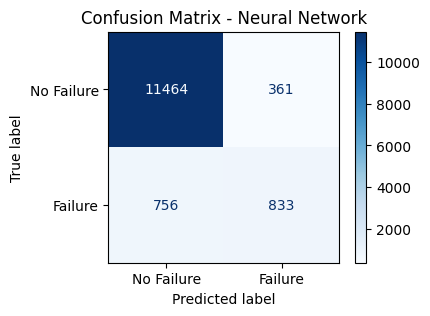

In [57]:
model_nn = Sequential()
model_nn.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))  # Capa de entrada con 64 neuronas y activación ReLU
model_nn.add(Dense(32, activation='relu'))  # Capa oculta con 32 neuronas y activación ReLU
model_nn.add(Dense(1, activation='sigmoid'))  # Capa de salida con 1 neurona y activación sigmoide para clasificación binaria

# Compilar la red neuronal
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Definir Early Stopping para detener el entrenamiento cuando no haya mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar la red neuronal con Early Stopping
history = model_nn.fit(X_train_resampled, y_train_resampled, 
                       epochs=100, batch_size=32, 
                       validation_split=0.2, 
                       callbacks=[early_stopping], 
                       verbose=1)

# Usar este nuevo modelo para predecir en el conjunto original
y_pred_prob_nn = model_nn.predict(X_train_new)[:, 0]  # Obtener la probabilidad de la clase 1 (falla)
y_pred_class_nn = (y_pred_prob_nn >= 0.5).astype(int)  # Clasificar en 0 o 1 basado en la probabilidad

# Agregar las predicciones al DataFrame original
df_complete_l33['predicted_failure_nn'] = y_pred_class_nn
df_complete_l33['predicted_failure_probability_nn'] = y_pred_prob_nn

# Evaluar el modelo utilizando AUC-ROC en el conjunto original
roc_auc_nn = roc_auc_score(y_train_new, y_pred_prob_nn)

# Calcular y mostrar las métricas de evaluación
print("Neural Network - Classification Report")
print(classification_report(y_train_new, y_pred_class_nn))
print(f"AUC-ROC: {roc_auc_nn:.4f}")

# Calcular la matriz de confusión
cm_nn = confusion_matrix(df_complete_l33['failure'], df_complete_l33['predicted_failure_nn'])

# Ajustar el tamaño de la figura
plt.figure(figsize=(4, 3))

# Crear y graficar la matriz de confusión
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=['No Failure', 'Failure'])
disp_nn.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Asegurar que la gráfica se ajuste al tamaño de la figura

# Añadir el título
plt.title("Confusion Matrix - Neural Network")
plt.show()

In [58]:
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC-ROC": []
}

# Función para calcular y almacenar las métricas
def store_metrics(model_name, y_true, y_pred, y_prob):
    results["Model"].append(model_name)
    results["Accuracy"].append(accuracy_score(y_true, y_pred))
    results["Precision"].append(precision_score(y_true, y_pred))
    results["Recall"].append(recall_score(y_true, y_pred))
    results["F1-Score"].append(f1_score(y_true, y_pred))
    results["AUC-ROC"].append(roc_auc_score(y_true, y_prob))

# Calcular y almacenar las métricas para cada modelo

# Random Forest
store_metrics("Random Forest", y_train_new, df_complete_l33['predicted_failure'], df_complete_l33['predicted_failure_probability'])

# Logistic Regression
store_metrics("Logistic Regression", y_train_new, df_complete_l33['predicted_failure_logistic'], df_complete_l33['predicted_failure_probability_logistic'])

# Decision Tree
store_metrics("Decision Tree", y_train_new, df_complete_l33['predicted_failure_tree'], df_complete_l33['predicted_failure_probability_tree'])

# SVM
store_metrics("SVM", y_train_new, df_complete_l33['predicted_failure_svm'], df_complete_l33['predicted_failure_probability_svm'])

# Neural Network
store_metrics("Neural Network", y_train_new, df_complete_l33['predicted_failure_nn'], df_complete_l33['predicted_failure_probability_nn'])

# Convertir los resultados a un DataFrame para facilitar la visualización
results_df = pd.DataFrame(results)

# Mostrar los resultados comparativos
print(results_df)

                 Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
0        Random Forest  0.898539   0.550802 0.777848  0.644926 0.922862
1  Logistic Regression  0.916729   0.697655 0.524229  0.598635 0.747953
2        Decision Tree  0.898539   0.550757 0.778477  0.645111 0.923562
3                  SVM  0.916803    0.69824 0.524229   0.59885 0.745397
4       Neural Network  0.916729   0.697655 0.524229  0.598635 0.748181


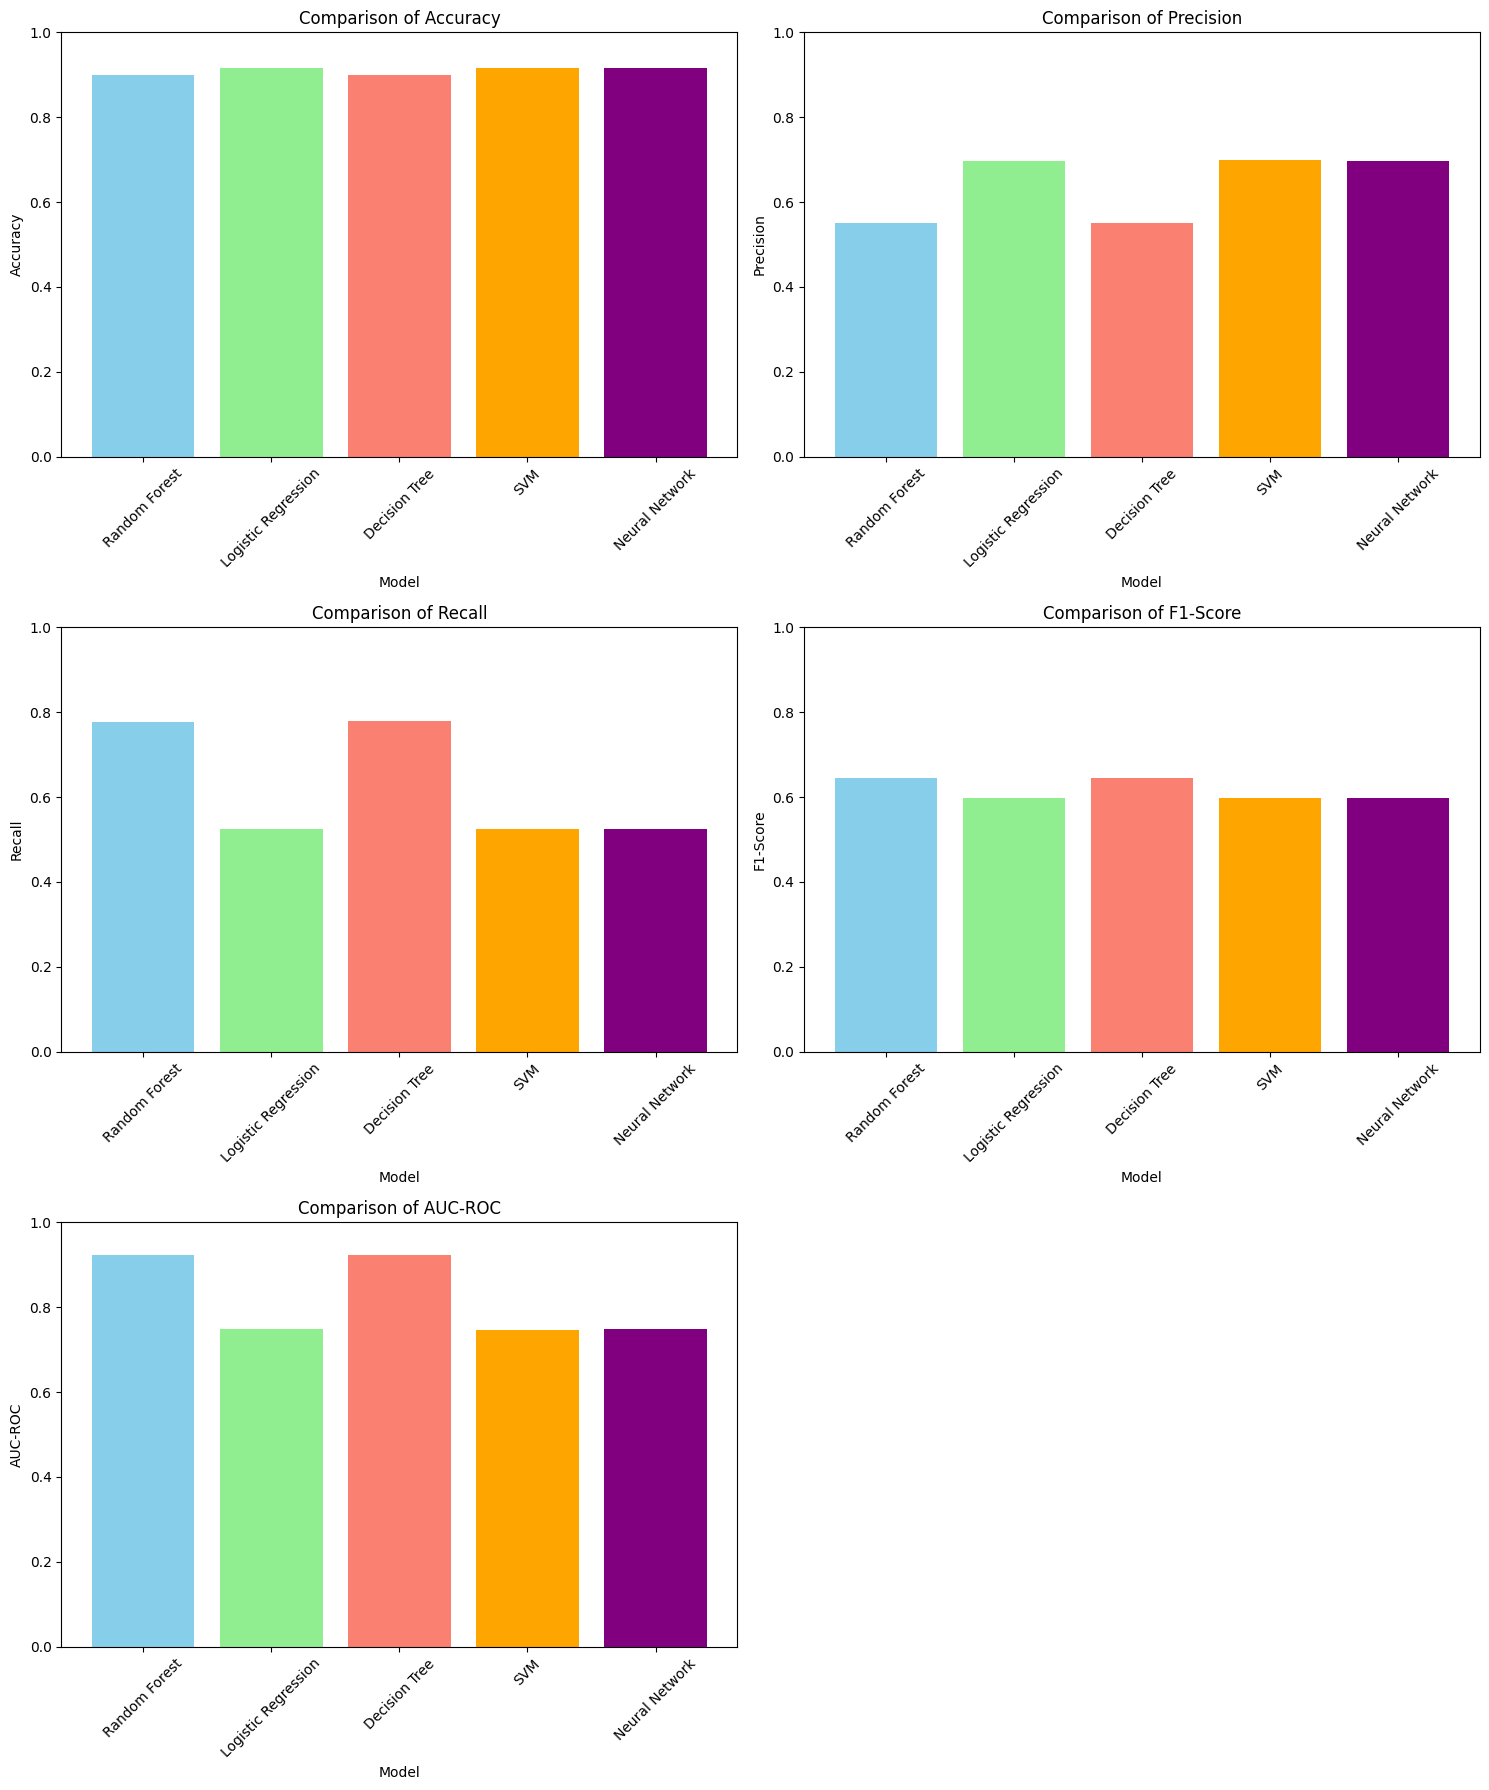

In [59]:
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'purple']

# Definir las métricas
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]

# Crear subplots (3 filas, 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.ravel()  # Para aplanar la matriz de ejes y poder iterar fácilmente

# Iterar sobre las métricas y gráficos
for i, metric in enumerate(metrics):
    axes[i].bar(results_df["Model"], results_df[metric], color=colors)
    axes[i].set_title(f'Comparison of {metric}')
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, 1)  # Asegura que el rango esté entre 0 y 1 para todas las métricas
    axes[i].tick_params(axis='x', rotation=45)  # Rotar las etiquetas en el eje x para evitar superposición

# Eliminar el sexto subplot vacío si no es necesario
if len(metrics) < len(axes):
    fig.delaxes(axes[-1])

# Ajustar la disposición y mostrar el gráfico
plt.tight_layout()
plt.show()